# Purpose
- One model, 3 datasets
- Compare Lap, AIC, BIC and MCMC
- Explore details of Lap
- Figures I want:
    - Lap and MCMC overlaid on the likelihood function
    - Table comparing the 3 datasets for all metrics

In [1]:
import sys
sys.path.insert(1, "..")
import pprint
import gpytorch
import torch
import numpy as np
import metrics
import copy
import configparser
from experiment_functions import Experiment
from GaussianProcess import ExactGPModel
from globalParams import options, hyperparameter_limits
import gpytorch
from helpFunctions import get_string_representation_of_kernel as gsr
from helpFunctions import clean_kernel_expression
from helpFunctions import get_kernels_in_kernel_expression, get_full_kernels_in_kernel_expression
from helpFunctions import amount_of_base_kernels
from itertools import product
import json
from kernelSearch import *
from matplotlib import pyplot as plt
from metrics import *
from multiprocessing import Pool
import numpy as np
import os
import pdb
import pickle
import random
import tikzplotlib
import time
import torch
from tqdm import tqdm
from scipy.stats import multivariate_normal
import matplotlib as mpl
from pygranso.pygranso import pygranso
from pygranso.pygransoStruct import pygransoStruct
from pygranso.private.getNvar import getNvarTorch

# To run STAN in a Jupyter notebook
import nest_asyncio
nest_asyncio.apply()



torch.manual_seed(42)


In [2]:
torch.set_default_dtype(torch.float64)

# Helper functions

In [3]:
def random_reinit(model):
    for i, (param, limit) in enumerate(zip(model.parameters(), [{"Noise": hyperparameter_limits["Noise"]},*[hyperparameter_limits[kernel] for kernel in get_full_kernels_in_kernel_expression(model.covar_module)]])):
        covar_text = gsr(model.covar_module)
        param_name = list(limit.keys())[0]
        new_param_value = torch.randn_like(param) * (limit[param_name][1] - limit[param_name][0]) + limit[param_name][0]
        param.data = new_param_value



# Define the training loop
def optimize_hyperparameters2(model, likelihood, **kwargs):
    """
    find optimal hyperparameters either by BO or by starting from random initial values multiple times, using an optimizer every time
    and then returning the best result
    """
    log_param_path = kwargs.get("log_param_path", False)
    log_likelihood = kwargs.get("log_likelihood", False)
    random_restarts = kwargs.get("random_restarts", options["training"]["restarts"]+1)
    line_search = kwargs.get("line_search", False)
    BFGS_iter = kwargs.get("BFGS_iter", 50)
    train_iterations = kwargs.get("train_iterations", 0)
    train_x = kwargs.get("X", model.train_inputs)
    train_y = kwargs.get("Y", model.train_targets)
    with_BFGS = kwargs.get("with_BFGS", False)
    history_size = kwargs.get("history_size", 100)
    MAP = kwargs.get("MAP", True)
    prior = kwargs.get("prior", False)
    granso = kwargs.get("granso", True)

    # Set up the likelihood and model
    #likelihood = gpytorch.likelihoods.GaussianLikelihood()
    #model = GPModel(train_x, train_y, likelihood)

    # Define the negative log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    # Set up the PyGRANSO optimizer
    opts = pygransoStruct()
    opts.torch_device = torch.device('cpu')
    nvar = getNvarTorch(model.parameters())
    opts.x0 = torch.nn.utils.parameters_to_vector(model.parameters()).detach().reshape(nvar,1)
    opts.opt_tol = float(1e-10)
    opts.limited_mem_size = int(100)
    opts.double_precision=False
    opts.globalAD = True
    opts.quadprog_info_msg = False
    opts.print_level = int(0)
    opts.halt_on_linesearch_bracket = False

    # Define the objective function
    def objective_function(model):
        output = model(train_x)
        loss = -mll(output, train_y)
        if MAP:
            log_p = log_normalized_prior(model)
            loss -= log_p
        return [loss, None, None]

    best_model_state_dict = model.state_dict()
    best_likelihood_state_dict = likelihood.state_dict()

    random_restarts = int(5)
    best_f = np.inf
    for restart in range(random_restarts):
        print(f"pre training parameters: {list(model.named_parameters())}")
        # Train the model using PyGRANSO
        soln = pygranso(var_spec=model, combined_fn=objective_function, user_opts=opts)
        if soln.final.f < best_f:
            best_f = soln.final.f
            best_model_state_dict = model.state_dict()
            best_likelihood_state_dict = likelihood.state_dict()
        print(f"post training (final): {list(model.named_parameters())} w. loss: {soln.final.f} (smaller=better)")
        random_reinit(model)

    model.load_state_dict(best_model_state_dict)
    likelihood.load_state_dict(best_likelihood_state_dict)

    loss = -mll(model(train_x), train_y)
    if MAP:
        log_p = log_normalized_prior(model)
        loss -= log_p

    print(f"post training (best): {list(model.named_parameters())} w. loss: {soln.best.f}")
    print(f"post training (final): {list(model.named_parameters())} w. loss: {soln.final.f}")
    
    print(torch.autograd.grad(loss, [p for p in model.parameters()], retain_graph=True, create_graph=True, allow_unused=True))
    # Return the trained model
    return loss, model, likelihood


def get_std_points(mu, K):
    x, y = np.mgrid[float(-3):float(3):float(.1), float(-3):float(3):float(.1)]
    rv = multivariate_normal(mu, K)
    L = np.linalg.cholesky(K)

    data = np.dstack((x, y))
    z = rv.pdf(data)

    # Drawing the unit circle
    # x^2 + y^2 = 1
    precision = int(50)
    unit_x = torch.cat([torch.linspace(float(-1), float(1), precision), torch.linspace(float(-1), float(1), precision)])
    unit_y = torch.cat([torch.sqrt(float(1) - torch.linspace(float(-1), float(1), precision)**float(2)), -torch.sqrt(float(1) - torch.linspace(float(-1), float(1), precision)**float(2))])

    new_unit_x = list()
    new_unit_y = list()

    for tx, ty in zip(unit_x, unit_y):
        res = np.array([tx, ty]) @ L
        new_unit_x.append(mu[0] + float(2)*res[0])
        new_unit_y.append(mu[1] + float(2)*res[1])
    return new_unit_x, new_unit_y



# Temp adam

In [4]:
def train_gp_with_adam(model, likelihood, train_x, train_y, num_epochs=100, lr=0.01):
    MAP = True
    # Set the model and likelihood to training mode
    model.train()
    likelihood.train()

    # Define the optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # Define the negative log likelihood loss
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    # Training loop
    for epoch in range(num_epochs):
        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        output = model(train_x)
        loss = -mll(output, train_y)
        params_list = [p for p in model.parameters()]
        env_grads_pre = torch.autograd.grad(loss, params_list, retain_graph=True, create_graph=True, allow_unused=True)
        if MAP:
            log_p = log_normalized_prior(model)
            loss -= log_p

        env_grads_post = torch.autograd.grad(loss, params_list, retain_graph=True, create_graph=True, allow_unused=True)
        print([post - pre for (post, pre) in zip(env_grads_post, env_grads_pre)])
        # Backward pass
        loss.backward()

        # Update the model parameters
        optimizer.step()

        # Print the loss for every 10 epochs
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}")

    # Set the model and likelihood back to evaluation mode
    model.eval()
    likelihood.eval()


In [5]:
class DataGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(DataGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = gpytorch.kernels.RBFKernel()

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


In [6]:
# Globals
figure_path = "CO2_figures"

# Data 

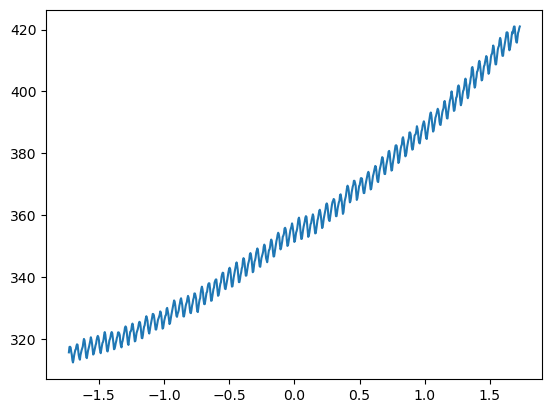

In [7]:
import math
torch.manual_seed(42)
END = 1
COUNT = 10
#dataset_name = "noise_linear"
#dataset_name = "noise_sin"
#dataset_name = "noise_parabolic"
#dataset_name = "noise_SE"
#dataset_name = "linear"
dataset_name = "CO2"
# linear
if "noise_linear" in dataset_name:
    train_x = torch.linspace(0, END, COUNT)
    train_y = torch.linspace(0, END, COUNT)
    train_y += torch.randn(train_x.size()) * torch.sqrt(torch.tensor(0.1))
elif "linear" == dataset_name:
    train_x = torch.tensor([-5.0000, -2.5000,  0.0000,  2.5000,  5.0000])
    train_y = torch.tensor([-2.6991e+00, -1.3503e+00,  6.4322e-04,  1.3510e+00,  2.7006e+00])
    train_x = (train_x - torch.mean(train_x)
                    ) / torch.std(train_x)
    #train_y = (train_y - torch.mean(train_y)
    #                  ) / torch.std(train_y)
    noise_level = 0.1
    train_y = train_y + torch.randn(train_y.shape) * torch.sqrt(torch.tensor(noise_level))

    train_x = torch.tensor([-1.2649, -0.6325,  0.0000,  0.6325,  1.2649])
    train_y = torch.tensor([ 0.0509, -0.2846,  0.1393,  0.3349, -0.1463])
elif "sin" in dataset_name:
# sin
    train_x = torch.linspace(0, 1, COUNT)
    train_y = torch.sin(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * torch.sqrt(torch.tensor(0.1)) 
##parabolic
elif "parabolic" in dataset_name:
    END = 2
    train_x = torch.linspace(-2, END, COUNT)
    train_y = train_x * train_x + 0.5 + torch.randn(train_x.size()) * torch.sqrt(torch.tensor(0.1)) 
elif "SE" in dataset_name:
    eval_START = -5
    eval_END = 5
    eval_COUNT = 5
    # training data for model initialization (e.g. 1 point with x=0, y=0) ; this makes initializing the model easier
    prior_x = torch.linspace(0, 1, 1)
    prior_y = prior_x
    # initialize likelihood and model
    data_likelihood = gpytorch.likelihoods.GaussianLikelihood()
    data_model = DataGPModel(prior_x, prior_y, data_likelihood)
    observations_x = torch.linspace(eval_START, eval_END, eval_COUNT)
    # Get into evaluation (predictive posterior) mode
    data_model.eval()
    data_likelihood.eval()

    # Make predictions by feeding model through likelihood
    with torch.no_grad(), gpytorch.settings.prior_mode(True):
        observed_pred_prior = data_likelihood(data_model(observations_x))
        f_preds = data_model(observations_x)


    EXPERIMENT_REPITITIONS = 50
    for exp_num in tqdm(range(EXPERIMENT_REPITITIONS)):
        observations_y = f_preds.sample()           # samples from the model
        # To store performance of kernels on a test dataset (i.e. more samples)
        original_observations_x = copy.deepcopy(observations_x)
        observations_x = (observations_x - torch.mean(observations_x)
                        ) / torch.std(observations_x)
        noise_level = 0.4
        observations_y = observations_y + torch.randn(observations_y.shape) * torch.tensor(noise_level)
        #observations_y = (observations_y - torch.mean(observations_y)
        #                  ) / torch.std(observations_y)
        train_x = observations_x
        train_y = observations_y
elif "CO2" in dataset_name:
    observations_x = list()
    observations_y = list()
    import csv
    #with open('co2_weekly_mlo.csv', newline='') as csvfile:
    with open('../co2_mm_mlo.csv', newline='') as csvfile:
        csv_data = csv.reader(csvfile, delimiter=',', quotechar='|')
        for row in csv_data:
            # The weekly dataset has one more col in front
            #if not row[4] == -999:
            #    observations_x.append(float(row[3]))
            #    observations_y.append(float(row[4]))
            if not row[3] == -999:
                observations_x.append(float(row[2]))
                observations_y.append(float(row[3]))
    X = torch.Tensor(observations_x) 
    Y = torch.Tensor(observations_y) 

    # Percentage noise
    # Z-Score scaling
    x_mean = torch.mean(X)
    x_std = torch.std(X)
    y_mean = torch.mean(Y)
    y_std = torch.std(Y)
    #X = (X - x_mean) / x_std 
    Y = (Y - y_mean)# / y_std 
    #X_test = X[int(len(X)*0.75):]
    #Y_test = Y[int(len(X)*0.75):]
    #X = X[:int(len(X)*0.75)]
    #Y = Y[:int(len(Y)*0.75)]
    def scale_back(data, X_dir = True):
        if X_dir: 
            return data*x_std + x_mean
        else:
            return data*y_std + y_mean

    train_x = X
    train_y = Y
    COUNT = len(train_x)

if not "CO2" in dataset_name:
    plt.plot(train_x, train_y, "o")
else:
    plt.plot(train_x, train_y)
#print(train_x)
#print(train_y)

plt.savefig(f"{figure_path}/data_{dataset_name}.png")
tikzplotlib.save(f"{figure_path}/data_{dataset_name}.tex")

# Model definition

In [8]:
#model_name = "c*SE"
#model_name = "c*SE+c*SE*PER"
#model_name = "c*SE+c*SE*PER+c*RQ"
model_name = "c*SE+c*SE*PER+c*RQ+c*SE"

#model_name = "SE"
#model_name = "SE+SE"
#model_name = "SE+SE*LIN"
#model_name = "SE+SE*PER"
#model_name = "LIN"
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, model_name="SE"):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        if model_name == "SE" or model_name == "c*SE":
            self.mean_module = gpytorch.means.ZeroMean()
            if model_name == "c*SE":
                self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
            else:
                self.covar_module = gpytorch.kernels.RBFKernel()
        elif model_name == "c*SE+c*SE*PER":
            self.mean_module = gpytorch.means.ZeroMean()
            self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel()) + gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel()*gpytorch.kernels.PeriodicKernel())
        elif model_name == "c*SE+c*SE*PER+c*RQ":
            self.mean_module = gpytorch.means.ZeroMean()
            self.covar_module = (gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel()) 
                    + gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel()*gpytorch.kernels.PeriodicKernel()) 
                    + gpytorch.kernels.ScaleKernel(gpytorch.kernels.RQKernel()))
        elif model_name == "c*SE+c*SE*PER+c*RQ+c*SE":
            self.mean_module = gpytorch.means.ZeroMean()
            self.covar_module = (gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel()) 
                    + gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel()*gpytorch.kernels.PeriodicKernel())
                    + gpytorch.kernels.ScaleKernel(gpytorch.kernels.RQKernel()) 
                    + gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel()))
        elif model_name == "SE+PER":
            self.mean_module = gpytorch.means.ZeroMean()
            self.covar_module = gpytorch.kernels.RBFKernel() + gpytorch.kernels.PeriodicKernel()
        elif model_name == "SE+SE*PER":
            self.mean_module = gpytorch.means.ZeroMean()
            self.covar_module = gpytorch.kernels.RBFKernel() + (gpytorch.kernels.PeriodicKernel()*gpytorch.kernels.RBFKernel())
        elif model_name == "SE+SE":
            self.mean_module = gpytorch.means.ZeroMean()
            self.covar_module = gpytorch.kernels.RBFKernel() + gpytorch.kernels.RBFKernel()
        elif model_name == "SE+SE*LIN":
            self.mean_module = gpytorch.means.ZeroMean()
            self.covar_module = gpytorch.kernels.RBFKernel() + (gpytorch.kernels.RBFKernel()*gpytorch.kernels.LinearKernel())
        elif model_name == "LIN":
            self.mean_module = gpytorch.means.ZeroMean()
            self.covar_module = gpytorch.kernels.LinearKernel()
        else:
            raise ValueError("Invalid model_name")

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
#likelihood = gpytorch.likelihoods.GaussianLikelihood(noise_constraint=gpytorch.constraints.GreaterThan(1e-30))
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood, model_name=model_name)

# Training

In [9]:
#train_gp_with_adam(model, likelihood, train_x, train_y, num_epochs=100, lr=0.01)

In [10]:
num_train_iter = 0
use_MAP = True 
use_LBFGS = False
LBFGS_iter = 50
# Train the MAP for 100 Iterations of ADAM and then 50 more of L-BFGS
loss, model, likelihood = optimize_hyperparameters2(model, likelihood,
                                                    X=train_x, 
                                                    Y=train_y
                                                   )
#loss,  model, likelihood = optimize_hyperparameters(model, likelihood, 
#                                                                 line_search=False, 
#                                                                 X=train_x, 
#                                                                 Y=train_y, 
#                                                                 train_iterations=0, 
#                                                                 #BFGS_iter=LBFGS_iter, 
#                                                                 #history_size=2*LBFGS_iter, 
#                                                                 #with_BFGS=use_LBFGS, 
#                                                                 #MAP=use_MAP, 
#                                                                 log_param_path=False, 
#                                                                 random_restarts=1, 
#                                                                 log_likelihood=False)


pre training parameters: [('likelihood.noise_covar.raw_noise', Parameter containing:
tensor([0.], requires_grad=True)), ('covar_module.kernels.0.raw_outputscale', Parameter containing:
tensor(0., requires_grad=True)), ('covar_module.kernels.0.base_kernel.raw_lengthscale', Parameter containing:
tensor([[0.]], requires_grad=True)), ('covar_module.kernels.1.raw_outputscale', Parameter containing:
tensor(0., requires_grad=True)), ('covar_module.kernels.1.base_kernel.kernels.0.raw_lengthscale', Parameter containing:
tensor([[0.]], requires_grad=True)), ('covar_module.kernels.1.base_kernel.kernels.1.raw_lengthscale', Parameter containing:
tensor([[0.]], requires_grad=True)), ('covar_module.kernels.1.base_kernel.kernels.1.raw_period_length', Parameter containing:
tensor([[0.]], requires_grad=True)), ('covar_module.kernels.2.raw_outputscale', Parameter containing:
tensor(0., requires_grad=True)), ('covar_module.kernels.2.base_kernel.raw_lengthscale', Parameter containing:
tensor([[0.]], requir

/home/besginow/anaconda3/envs/sage/lib/python3.10/site-packages/pygranso/private/bfgsHessianInverseLimitedMem.py:237: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /home/conda/feedstock_root/build_artifacts/pytorch-recipe_1675740247391/work/aten/src/ATen/native/TensorShape.cpp:3277.)
  alpha[j,:]  = self.rho[0,j] * (self.S[:,j].T  @ q)


post training (final): [('likelihood.noise_covar.raw_noise', Parameter containing:
tensor([4.5882], requires_grad=True)), ('covar_module.kernels.0.raw_outputscale', Parameter containing:
tensor(31.0567, requires_grad=True)), ('covar_module.kernels.0.base_kernel.raw_lengthscale', Parameter containing:
tensor([[5.9638]], requires_grad=True)), ('covar_module.kernels.1.raw_outputscale', Parameter containing:
tensor(24.9105, requires_grad=True)), ('covar_module.kernels.1.base_kernel.kernels.0.raw_lengthscale', Parameter containing:
tensor([[0.8156]], requires_grad=True)), ('covar_module.kernels.1.base_kernel.kernels.1.raw_lengthscale', Parameter containing:
tensor([[4.8375]], requires_grad=True)), ('covar_module.kernels.1.base_kernel.kernels.1.raw_period_length', Parameter containing:
tensor([[1.9603]], requires_grad=True)), ('covar_module.kernels.2.raw_outputscale', Parameter containing:
tensor(31.7905, requires_grad=True)), ('covar_module.kernels.2.base_kernel.raw_lengthscale', Parameter 

In [11]:
loss

tensor(3.7107, grad_fn=<SubBackward0>)

In [12]:
list(model.named_parameters())

[('likelihood.noise_covar.raw_noise',
  Parameter containing:
  tensor([4.5882], requires_grad=True)),
 ('covar_module.kernels.0.raw_outputscale',
  Parameter containing:
  tensor(31.0567, requires_grad=True)),
 ('covar_module.kernels.0.base_kernel.raw_lengthscale',
  Parameter containing:
  tensor([[5.9638]], requires_grad=True)),
 ('covar_module.kernels.1.raw_outputscale',
  Parameter containing:
  tensor(24.9105, requires_grad=True)),
 ('covar_module.kernels.1.base_kernel.kernels.0.raw_lengthscale',
  Parameter containing:
  tensor([[0.8156]], requires_grad=True)),
 ('covar_module.kernels.1.base_kernel.kernels.1.raw_lengthscale',
  Parameter containing:
  tensor([[4.8375]], requires_grad=True)),
 ('covar_module.kernels.1.base_kernel.kernels.1.raw_period_length',
  Parameter containing:
  tensor([[1.9603]], requires_grad=True)),
 ('covar_module.kernels.2.raw_outputscale',
  Parameter containing:
  tensor(31.7905, requires_grad=True)),
 ('covar_module.kernels.2.base_kernel.raw_lengths

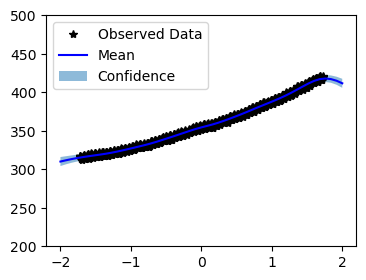

In [13]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(-2, 2, 51)
    a = model(test_x)
    observed_pred = likelihood(a)
    
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(4, 3))

    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    ax.plot(train_x.numpy(), train_y.numpy(), 'k*')
    # Plot predictive means as blue line
    ax.plot(test_x.numpy(), observed_pred.mean.numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    ax.set_ylim([-4, 7])
    if "CO2" in dataset_name:
        ax.set_ylim([200, 500])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])

plt.savefig(f"{figure_path}/{model_name}_{dataset_name}_posterior.png")
tikzplotlib.save(f"{figure_path}/{model_name}_{dataset_name}_posterior.tex")

# Laplace

In [14]:
#print(f"L-BFGS iterations: {len(training_log['log_likelihood']) - num_train_iter}")
model.train()
likelihood.train()
lap_approx_S, lap_log_S = metrics.calculate_laplace(model, -loss*len(*model.train_inputs), param_punish_term=0.0)
lap_approx_AIC, lap_log_AIC = metrics.calculate_laplace(model, -loss*len(*model.train_inputs), param_punish_term=-1.0)
lap_approx_BIC, lap_log_BIC = metrics.calculate_laplace(model, -loss*len(*model.train_inputs), param_punish_term="BIC")
print(lap_approx_S)
print(lap_log_S)
print(lap_approx_AIC)
print(lap_log_AIC)
print(lap_approx_BIC)
print(lap_log_BIC)

# Draw the distribution defined by the mean (found parametrization) and covariance matrix (Hessian)
# (4.133) in Bishop, 2006: f(z) ~ f(z_0)exp(-0.5 (z-z_0)^T H (z-z_0)) with z the parameters, and H the Hessian
# We just leave out the f(z_0)

#scaling_factor = lap_log["neg MLL"]
#mu = [p.item() for p in list(model.parameters())]
##mu = [training_log["log_param_path"][param_keys[0]][-1], training_log["log_param_path"][param_keys[1]][-1]]
#K = lap_log["corrected Hessian"]
#new_unit_x, new_unit_y = get_std_points(mu, K.inverse()[:2, :2])
#plt.scatter(new_unit_x, new_unit_y, color="grey", s=3)
#K = lap_log["original symmetrized Hessian"]
#new_unit_x, new_unit_y = get_std_points(mu, K.inverse()[:2, :2])
#plt.scatter(new_unit_x, new_unit_y, color="black", s=3)
#

trained_mu = [p.item() for p in list(model.parameters())]

tensor(-2900.2530, dtype=torch.float64, grad_fn=<AddBackward0>)
{'neg MLL': tensor(2898.0613, dtype=torch.float64, grad_fn=<NegBackward0>), 'punish term': tensor(-2.1917, dtype=torch.float64), 'laplace without replacement': tensor(-2888.5473, dtype=torch.float64, grad_fn=<SubBackward0>), 'num_replaced': tensor(9), 'parameter list': ['likelihood.noise_covar.raw_noise', 'covar_module.kernels.0.raw_outputscale', 'covar_module.kernels.0.base_kernel.raw_lengthscale', 'covar_module.kernels.1.raw_outputscale', 'covar_module.kernels.1.base_kernel.kernels.0.raw_lengthscale', 'covar_module.kernels.1.base_kernel.kernels.1.raw_lengthscale', 'covar_module.kernels.1.base_kernel.kernels.1.raw_period_length', 'covar_module.kernels.2.raw_outputscale', 'covar_module.kernels.2.base_kernel.raw_lengthscale', 'covar_module.kernels.2.base_kernel.raw_alpha', 'covar_module.kernels.3.raw_outputscale', 'covar_module.kernels.3.base_kernel.raw_lengthscale'], 'Jacobian': (tensor([-4.7364e-06], dtype=torch.float64, 

/home/besginow/code/LaplaceKernelSearch/exploration_tests/../metrics.py:125: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [max(val, (torch.exp(torch.tensor(-2*param_punish_term))*(2*torch.pi))) for i, val in enumerate(vals)]))


In [15]:
MLL_loss, model, likelihood = optimize_hyperparameters2(model, likelihood,
                                                        X=train_x, 
                                                        Y=train_y,
                                                        MAP=False
                                                       )

pre training parameters: [('likelihood.noise_covar.raw_noise', Parameter containing:
tensor([4.5882], dtype=torch.float64, requires_grad=True)), ('covar_module.kernels.0.raw_outputscale', Parameter containing:
tensor(31.0567, dtype=torch.float64, requires_grad=True)), ('covar_module.kernels.0.base_kernel.raw_lengthscale', Parameter containing:
tensor([[5.9638]], dtype=torch.float64, requires_grad=True)), ('covar_module.kernels.1.raw_outputscale', Parameter containing:
tensor(24.9105, dtype=torch.float64, requires_grad=True)), ('covar_module.kernels.1.base_kernel.kernels.0.raw_lengthscale', Parameter containing:
tensor([[0.8156]], dtype=torch.float64, requires_grad=True)), ('covar_module.kernels.1.base_kernel.kernels.1.raw_lengthscale', Parameter containing:
tensor([[4.8375]], dtype=torch.float64, requires_grad=True)), ('covar_module.kernels.1.base_kernel.kernels.1.raw_period_length', Parameter containing:
tensor([[1.9603]], dtype=torch.float64, requires_grad=True)), ('covar_module.kern

post training (final): [('likelihood.noise_covar.raw_noise', Parameter containing:
tensor([4.5824], dtype=torch.float64, requires_grad=True)), ('covar_module.kernels.0.raw_outputscale', Parameter containing:
tensor(270.7484, dtype=torch.float64, requires_grad=True)), ('covar_module.kernels.0.base_kernel.raw_lengthscale', Parameter containing:
tensor([[14.5431]], dtype=torch.float64, requires_grad=True)), ('covar_module.kernels.1.raw_outputscale', Parameter containing:
tensor(251.2042, dtype=torch.float64, requires_grad=True)), ('covar_module.kernels.1.base_kernel.kernels.0.raw_lengthscale', Parameter containing:
tensor([[1.1958]], dtype=torch.float64, requires_grad=True)), ('covar_module.kernels.1.base_kernel.kernels.1.raw_lengthscale', Parameter containing:
tensor([[16.0201]], dtype=torch.float64, requires_grad=True)), ('covar_module.kernels.1.base_kernel.kernels.1.raw_period_length', Parameter containing:
tensor([[2.1073]], dtype=torch.float64, requires_grad=True)), ('covar_module.ke

In [16]:
AIC_approx, AIC_log = calculate_AIC(-MLL_loss*len(train_x), len(trained_mu))
print(AIC_approx)
print(AIC_log)

tensor(-3653.2864, dtype=torch.float64, grad_fn=<AddBackward0>)
{'punish term': 24, 'Total time': 1.7642974853515625e-05, 'loss term': tensor(-3629.2864, dtype=torch.float64, grad_fn=<MulBackward0>)}


In [17]:
BIC_approx, BIC_log = calculate_BIC(-MLL_loss*len(train_x), len(trained_mu), torch.tensor(len(train_x)))
print(BIC_approx)
print(BIC_log)

tensor(-3709.2133, dtype=torch.float64, grad_fn=<AddBackward0>)
{'punish term': tensor(-79.9269), 'Total time': 5.030632019042969e-05, 'loss term': tensor(-3629.2864, dtype=torch.float64, grad_fn=<MulBackward0>)}


In [18]:
#Startparameter:
#[('likelihood.noise_covar.raw_noise', Parameter containing:
#tensor([-5.2771], requires_grad=True)), ('covar_module.raw_lengthscale', Parameter containing:
#tensor([[0.4671]], requires_grad=True))]

In [19]:

print(list(model.parameters()))

[Parameter containing:
tensor([4.5824], dtype=torch.float64, requires_grad=True), Parameter containing:
tensor(270.7484, dtype=torch.float64, requires_grad=True), Parameter containing:
tensor([[14.5431]], dtype=torch.float64, requires_grad=True), Parameter containing:
tensor(251.2042, dtype=torch.float64, requires_grad=True), Parameter containing:
tensor([[1.1958]], dtype=torch.float64, requires_grad=True), Parameter containing:
tensor([[16.0201]], dtype=torch.float64, requires_grad=True), Parameter containing:
tensor([[2.1073]], dtype=torch.float64, requires_grad=True), Parameter containing:
tensor(269.3518, dtype=torch.float64, requires_grad=True), Parameter containing:
tensor([[11.0308]], dtype=torch.float64, requires_grad=True), Parameter containing:
tensor([-5.5395], dtype=torch.float64, requires_grad=True), Parameter containing:
tensor(270.7484, dtype=torch.float64, requires_grad=True), Parameter containing:
tensor([[14.5431]], dtype=torch.float64, requires_grad=True)]


In [20]:
print(f"{model_name}")
print(f"data & LODE model & Lap\\_0 & Lap\\_AIC & Lap\\_BIC & AIC & BIC & MLL & MAP\\\\")
print(f"{dataset_name} & {model_name} & {lap_approx_S:.2f} & {lap_approx_AIC:.2f} & {lap_approx_BIC:.2f} & {-AIC_approx:.2f} & {-BIC_approx:.2f} & {-MLL_loss*model.train_targets.numel():.2f} & {-loss*model.train_targets.numel():.2f}\\\\")


c*SE+c*SE*PER+c*RQ+c*SE
data & LODE model & Lap\_0 & Lap\_AIC & Lap\_BIC & AIC & BIC & MLL & MAP\\
CO2 & c*SE+c*SE*PER+c*RQ+c*SE & -2900.25 & -2910.16 & -2977.99 & 3653.29 & 3709.21 & -1814.64 & -2898.06\\


data & LODE model             & Lap\_0   & Lap\_AIC & Lap\_BIC & AIC     & BIC    & MLL       & MAP\\
CO2 & c*SE                    & -4022.24 & -4024.06 & -4039.65 & 3771.91 & 3785.89 & -1882.96 & -4019.67\\
CO2 & c*SE+c*SE*PER           & -3211.92 & -3216.42 & -3255.57 & 3661.84 & 3694.46 & -1823.92 & -3208.95\\
CO2 & c*SE+c*SE*PER+c*RQ      & -2254.80 & -2261.55 & -2315.70 & 1968.86 & 2015.47 & -974.43  & -2249.10\\
CO2 & c*SE+c*SE*PER+c*RQ+c*SE & -2900.25 & -2910.16 & -2977.99 & 3653.29 & 3709.21 & -1814.64 & -2898.06\\


k1+k2:

(MAP)
post training (final): [('likelihood.noise_covar.raw_noise', Parameter containing:
tensor([4.6473], requires_grad=True)), ('covar_module.kernels.0.raw_outputscale', Parameter containing:
tensor(53.5160, requires_grad=True)), ('covar_module.kernels.0.base_kernel.raw_lengthscale', Parameter containing:
tensor([[9.2507]], requires_grad=True)), ('covar_module.kernels.1.raw_outputscale', Parameter containing:
tensor(42.7928, requires_grad=True)), ('covar_module.kernels.1.base_kernel.kernels.0.raw_lengthscale', Parameter containing:
tensor([[2.2457]], requires_grad=True)), ('covar_module.kernels.1.base_kernel.kernels.1.raw_lengthscale', Parameter containing:
tensor([[4.3578]], requires_grad=True)), ('covar_module.kernels.1.base_kernel.kernels.1.raw_period_length', Parameter containing:
tensor([[2.7218]], requires_grad=True))] w. loss: 4.108769188666716 (smaller=better)

(Likelihood)
[Parameter containing:
tensor([4.6603], dtype=torch.float64, requires_grad=True), Parameter containing:
tensor(523.3132, dtype=torch.float64, requires_grad=True), Parameter containing:
tensor([[7.5767]], dtype=torch.float64, requires_grad=True), Parameter containing:
tensor(489.2108, dtype=torch.float64, requires_grad=True), Parameter containing:
tensor([[4.6906]], dtype=torch.float64, requires_grad=True), Parameter containing:
tensor([[5.3023]], dtype=torch.float64, requires_grad=True), Parameter containing:
tensor([[5.3139]], dtype=torch.float64, requires_grad=True)]

k1+k2+k3

(MAP)
post training (final): [('likelihood.noise_covar.raw_noise', Parameter containing:
tensor([-3.6123], requires_grad=True)), ('covar_module.kernels.0.raw_outputscale', Parameter containing:
tensor(39.6881, requires_grad=True)), ('covar_module.kernels.0.base_kernel.raw_lengthscale', Parameter containing:
tensor([[5.0311]], requires_grad=True)), ('covar_module.kernels.1.raw_outputscale', Parameter containing:
tensor(37.6640, requires_grad=True)), ('covar_module.kernels.1.base_kernel.kernels.0.raw_lengthscale', Parameter containing:
tensor([[4.7060]], requires_grad=True)), ('covar_module.kernels.1.base_kernel.kernels.1.raw_lengthscale', Parameter containing:
tensor([[8.6872]], requires_grad=True)), ('covar_module.kernels.1.base_kernel.kernels.1.raw_period_length', Parameter containing:
tensor([[3.8607]], requires_grad=True)), ('covar_module.kernels.2.raw_outputscale', Parameter containing:
tensor(37.1519, requires_grad=True)), ('covar_module.kernels.2.base_kernel.raw_lengthscale', Parameter containing:
tensor([[-3.5266]], requires_grad=True)), ('covar_module.kernels.2.base_kernel.raw_alpha', Parameter containing:
tensor([-2.6233], requires_grad=True))] w. loss: 2.8797677286381598

(Likelihood)
[Parameter containing:
tensor([-3.2612], dtype=torch.float64, requires_grad=True), Parameter containing:
tensor(389.8698, dtype=torch.float64, requires_grad=True), Parameter containing:
tensor([[24.4240]], dtype=torch.float64, requires_grad=True), Parameter containing:
tensor(375.5222, dtype=torch.float64, requires_grad=True), Parameter containing:
tensor([[2.5956]], dtype=torch.float64, requires_grad=True), Parameter containing:
tensor([[39.3095]], dtype=torch.float64, requires_grad=True), Parameter containing:
tensor([[73.0814]], dtype=torch.float64, requires_grad=True), Parameter containing:
tensor(377.6503, dtype=torch.float64, requires_grad=True), Parameter containing:
tensor([[-2.6020]], dtype=torch.float64, requires_grad=True), Parameter containing:
tensor([-3.6628], dtype=torch.float64, requires_grad=True)]


k1+k2+k3+k4

(MAP)
[('likelihood.noise_covar.raw_noise',
  Parameter containing:
  tensor([4.5882], requires_grad=True)),
 ('covar_module.kernels.0.raw_outputscale',
  Parameter containing:
  tensor(31.0567, requires_grad=True)),
 ('covar_module.kernels.0.base_kernel.raw_lengthscale',
  Parameter containing:
  tensor([[5.9638]], requires_grad=True)),
 ('covar_module.kernels.1.raw_outputscale',
  Parameter containing:
  tensor(24.9105, requires_grad=True)),
 ('covar_module.kernels.1.base_kernel.kernels.0.raw_lengthscale',
  Parameter containing:
  tensor([[0.8156]], requires_grad=True)),
 ('covar_module.kernels.1.base_kernel.kernels.1.raw_lengthscale',
  Parameter containing:
  tensor([[4.8375]], requires_grad=True)),
 ('covar_module.kernels.1.base_kernel.kernels.1.raw_period_length',
  Parameter containing:
  tensor([[1.9603]], requires_grad=True)),
 ('covar_module.kernels.2.raw_outputscale',
  Parameter containing:
  tensor(31.7905, requires_grad=True)),
 ('covar_module.kernels.2.base_kernel.raw_lengthscale',
  Parameter containing:
  tensor([[1.5671]], requires_grad=True)),
 ('covar_module.kernels.2.base_kernel.raw_alpha',
  Parameter containing:
  tensor([-5.3406], requires_grad=True)),
 ('covar_module.kernels.3.raw_outputscale',
  Parameter containing:
  tensor(31.0567, requires_grad=True)),
 ('covar_module.kernels.3.base_kernel.raw_lengthscale',
  Parameter containing:
  tensor([[5.9638]], requires_grad=True))]

(Likelihood)
[Parameter containing: tensor([4.5824], dtype=torch.float64, requires_grad=True), 
Parameter containing: tensor(270.7484, dtype=torch.float64, requires_grad=True),
Parameter containing: tensor([[14.5431]], dtype=torch.float64, requires_grad=True),
Parameter containing: tensor(251.2042, dtype=torch.float64, requires_grad=True),
Parameter containing: tensor([[1.1958]], dtype=torch.float64, requires_grad=True),
Parameter containing: tensor([[16.0201]], dtype=torch.float64, requires_grad=True),
Parameter containing: tensor([[2.1073]], dtype=torch.float64, requires_grad=True),
Parameter containing: tensor(269.3518, dtype=torch.float64, requires_grad=True),
Parameter containing: tensor([[11.0308]], dtype=torch.float64, requires_grad=True),
Parameter containing: tensor([-5.5395], dtype=torch.float64, requires_grad=True),
Parameter containing: tensor(270.7484, dtype=torch.float64, requires_grad=True),
Parameter containing: tensor([[14.5431]], dtype=torch.float64, requires_grad=True)]

# MCMC

In [21]:
from metrics import calculate_mc_STAN
# Perform MCMC
MCMC_approx, MC_log = calculate_mc_STAN(
    model, likelihood, 1000, log_param_path=True, 
    log_full_likelihood=True, log_full_posterior=True, 
    log_kernel_data=True)
print(MCMC_approx)

> /home/besginow/code/LaplaceKernelSearch/metrics.py(565)calculate_mc_STAN()
    563                     import pdb
    564                     pdb.set_trace()
--> 565         prev_cov = cov_str
    566     theta_mu = torch.tensor(theta_mu)
    567     theta_mu = theta_mu.unsqueeze(0).t()



BdbQuit: 

585

# MC Figures

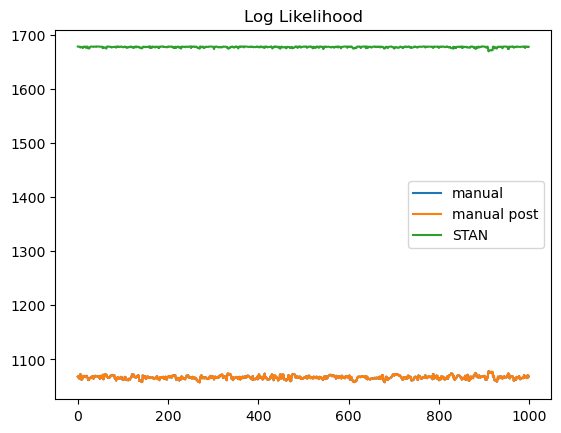

In [ ]:
plt.plot(MC_log['manual lp list'])
plt.plot(MC_log["manual post list"])
plt.plot(MC_log["STAN_like_approx"])
plt.legend(["manual", "manual post", "STAN"])
plt.title("Log Likelihood")
plt.savefig(f"{figure_path}/{model_name}_{dataset_name}_log_likelihood_MCMC_draws.png")
tikzplotlib.save(f"{figure_path}/{model_name}_{dataset_name}_log_likelihood_MCMC_draws.tex")

{'theta.1': {'mu': -9.839176637015784, 'var': 0.006504263295107339},
 'theta.2': {'mu': -4.039866248608631, 'var': 8.612855850430865e-05}}
{'mu': tensor([[-3.5164],
        [-0.2122]]), 'var': tensor([[12.8388,  0.0000],
        [ 0.0000,  3.5704]])}


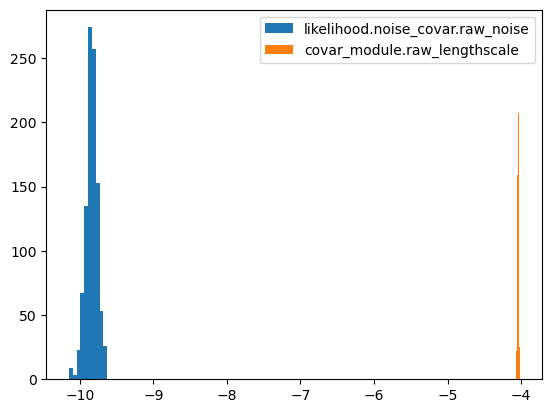

In [ ]:

import pprint
pprint.pprint(MC_log["Parameter statistics"])
for param_name in MC_log['param draws dict']:
    plt.hist(MC_log['param draws dict'][param_name])
print(MC_log["Parameter prior"])
plt.legend([param[0] for param in model.named_parameters()])
plt.savefig(f"{figure_path}/{model_name}_{dataset_name}_MCMC_param_distribution.png")
tikzplotlib.save(f"{figure_path}/{model_name}_{dataset_name}_MCMC_param_distribution.tex")

0.0
0.0
0.0
0.0


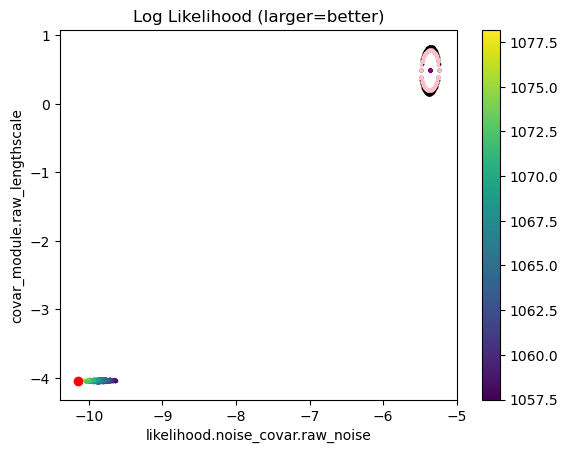

In [ ]:
#
#scaling_factor = lap_log["neg MLL"]
#mu = [training_log["training_log"][param_keys[0]][-1], training_log["training_log"][param_keys[1]][-1]]
#K = lap_log["corrected Hessian"]
#new_unit_x, new_unit_y = get_std_points(mu, K)
##plt.scatter(new_unit_x, new_unit_y, color="grey", s=3)
#K = lap_log["original symmetrized Hessian"]
#new_unit_x, new_unit_y = get_std_points(mu, K)
#plt.scatter(new_unit_x, new_unit_y, color="black", s=3)
#

def check_if_in_interval(mu_vector, cov_matr, point, interval):
    # Create a multivariate normal distribution object
    mvn = multivariate_normal(mean=mu_vector, cov=cov_matr)
    # Calculate the probability of the datapoint
    probability = mvn.pdf(point)
    # Calculate the 2 standard deviation interval
    lower_bound = mvn.pdf(mu_vector + interval * np.sqrt(cov_matr[0][0]))
    # Check if the probability lies within the 2 standard deviation interval
    return probability >= lower_bound




def get_sub_tensor(tensor, num1, num2):
    sub_tensor = tensor[[num1, num2]][:, [num1, num2]]
    return sub_tensor


draw_prior=False
draw_uncorrected=False

what_to_draw = "manual lp list" # likelihood surface 
#what_to_draw = "manual post list" # posterior surface
#what_to_draw = "STAN_like_approx" # STAN likelihood surface

param_names = [param[0] for param in model.named_parameters()]

plot_param1 = "theta.1" 
plot_param2 = "theta.2" 
row_num = int(plot_param1[-1:]) - int(1) 
col_num = int(plot_param2[-1:]) - int(1)


filtered = False 
filtered_noise = list()
filtered_length = list()
filtered_loglike = list()

# loop to filter draws below X 
for n, l, llik in zip(MC_log['param draws dict'][plot_param1], MC_log['param draws dict'][plot_param2], MC_log[what_to_draw]):
    if llik > int(-100):
        filtered_noise.append(n)
        filtered_length.append(l)
        filtered_loglike.append(llik)

if filtered:
    for i in range(len(filtered_noise)-1):
        n, l = filtered_noise[i], filtered_length[i]
        n2, l2 = filtered_noise[i+1], filtered_length[i+1]
        #plt.arrow(n, l, n2-n, l2-l, color=mpl.colormaps["Greens"](i/len(filtered_noise)), head_length = 0.07, head_width = 0.025, length_includes_head = True)
    plt.scatter(filtered_noise, filtered_length, c=filtered_loglike, s=3)
    max_index = MC_log[what_to_draw].index(max(MC_log[what_to_draw]))
    #print(f"{max(MC_log[what_to_draw])} : {MC_log['param draws dict']['theta.1'][max_index]} {MC_log['param draws dict']['theta.2'][max_index]}")
    plt.plot(MC_log['param draws dict'][plot_param1][max_index], MC_log['param draws dict'][plot_param2][max_index], "ro")
else:
    for i in range(len(MC_log['param draws dict'][plot_param1])-1):
        n, l = MC_log['param draws dict'][plot_param1][i], MC_log['param draws dict'][plot_param2][i]
        n2, l2 = MC_log['param draws dict'][plot_param1][i+int(1)], MC_log['param draws dict'][plot_param2][i+int(1)]
        #plt.arrow(n, l, n2-n, l2-l, color=mpl.colormaps["Greens"](i/len(MC_log['param draws dict'][plot_param1])), head_length = 0.07, head_width = 0.025, length_includes_head = True)
    plt.scatter(MC_log['param draws dict'][plot_param1], MC_log['param draws dict'][plot_param2], c=torch.Tensor(MC_log[what_to_draw]), s=3)
    max_index = MC_log[what_to_draw].index(max(MC_log[what_to_draw]))
    plt.plot(MC_log['param draws dict'][plot_param1][max_index], MC_log['param draws dict'][plot_param2][max_index], "ro")


plt.colorbar()


mu = torch.tensor(trained_mu)[[row_num, col_num]]
K = lap_log_S["corrected Hessian"]
new_unit_x, new_unit_y = get_std_points(mu, get_sub_tensor(K.inverse(), row_num, col_num))
plt.scatter(new_unit_x, new_unit_y, color="black", s=3)
print(f"{100*sum([check_if_in_interval(torch.tensor(trained_mu), K.inverse(), sample, 2) for sample in [list(sample[1]) for sample in MC_log['param draws dict'].iterrows()]]) / len(MC_log[what_to_draw])}")


K = lap_log_AIC["corrected Hessian"]
new_unit_x, new_unit_y = get_std_points(mu, get_sub_tensor(K.inverse(), row_num, col_num))
plt.scatter(new_unit_x, new_unit_y, color="pink", s=3)
print(f"{100*sum([check_if_in_interval(torch.tensor(trained_mu), K.inverse(), sample, 2) for sample in [list(sample[1]) for sample in MC_log['param draws dict'].iterrows()]]) / len(MC_log[what_to_draw])}")

K = lap_log_BIC["corrected Hessian"]
new_unit_x, new_unit_y = get_std_points(mu, get_sub_tensor(K.inverse(), row_num, col_num))
plt.scatter(new_unit_x, new_unit_y, color="purple", s=3)
print(f"{100*sum([check_if_in_interval(torch.tensor(trained_mu), K.inverse(), sample, 2) for sample in [list(sample[1]) for sample in MC_log['param draws dict'].iterrows()]]) / len(MC_log[what_to_draw])}")


new_unit_x, new_unit_y = get_std_points(MC_log["Parameter prior"]["mu"].flatten()[[row_num, col_num]], get_sub_tensor(MC_log["Parameter prior"]["var"], row_num, col_num))
if draw_prior or what_to_draw == "manual post list": 
    plt.scatter(new_unit_x, new_unit_y, color="gray", s=3)
K = lap_log_S["original symmetrized Hessian"]
print(f"{100*sum([check_if_in_interval(torch.tensor(trained_mu), K.inverse(), sample, 2) for sample in [list(sample[1]) for sample in MC_log['param draws dict'].iterrows()]]) / len(MC_log[what_to_draw])}")
try:
    new_unit_x, new_unit_y = get_std_points(mu, get_sub_tensor(K.inverse(), row_num, col_num))
    if draw_uncorrected: 
        plt.scatter(new_unit_x, new_unit_y, color="turquoise", s=3)
except: 
    pass
plt.xlabel(param_names[row_num])
plt.ylabel(param_names[col_num])
plt.title(f"Log {'Likelihood' if 'lp' in what_to_draw else 'Posterior'} (larger=better)")

plt.savefig(f"{figure_path}/{model_name}_{dataset_name}_MCMC_{'likelihood' if 'lp' in what_to_draw else 'posterior'}_surface_{param_names[row_num]}-{param_names[col_num]}.png")
tikzplotlib.save(f"{figure_path}/{model_name}_{dataset_name}_MCMC_{'likelihood' if 'lp' in what_to_draw else 'posterior'}_surface_{param_names[row_num]}-{param_names[col_num]}.tex")

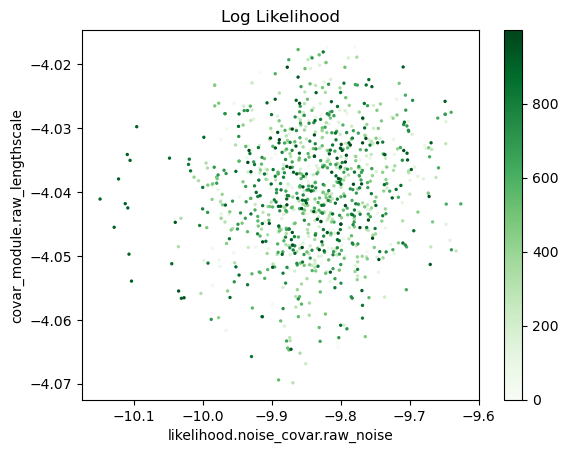

In [ ]:
# Contour plot of the likelihood surface according to the explored samples
# loop to filter draws below -5000
#plot_param1 = "theta.2" 
#plot_param2 = "theta.3" 
#row_num = int(plot_param1[-1:]) - int(1) 
#col_num = int(plot_param2[-1:]) - int(1)


filtered_noise = list()
filtered_length = list()
filtered_loglike = list()
for n, l, llik in zip(MC_log['param draws dict'][plot_param1], MC_log['param draws dict'][plot_param2], MC_log[what_to_draw]):
    if llik > int(-5000):
        filtered_noise.append(n)
        filtered_length.append(l)
        filtered_loglike.append(llik)
plt.scatter(MC_log['param draws dict'][plot_param1], MC_log['param draws dict'][plot_param2], c=range(len(MC_log['param draws dict'][plot_param2])), cmap="Greens", s=2)
plt.colorbar() 
## Drawing the parameter Prior
#new_unit_x, new_unit_y = get_std_points(MC_log["Parameter prior"]["mu"].numpy().T[0][:2], MC_log["Parameter prior"]["var"].inverse()[:2, :2])
# Draw one standard deviation around the center of the distribution
#plt.scatter(new_unit_x, new_unit_y, color="pink", s=3)
#plt.scatter(filtered_noise, filtered_length, c=filtered_loglike)

plt.xlabel(param_names[row_num])
plt.ylabel(param_names[col_num])
plt.title("Log Likelihood")

plt.savefig(f"{figure_path}/{model_name}_{dataset_name}_MCMC_likelihood_path_{param_names[row_num]}-{param_names[col_num]}.png")
tikzplotlib.save(f"{figure_path}/{model_name}_{dataset_name}_MCMC_likelihood_path_{param_names[row_num]}-{param_names[col_num]}.tex")

In [ ]:
print(f"{model_name}")
print(f"data & LODE model & MCMC & Lap\\_0 & Lap\\_AIC & Lap\\_BIC & AIC & BIC & MLL & MAP\\\\")
print(f"{dataset_name} & {model_name} & {MCMC_approx:.2f} & {lap_approx_S:.2f} & {lap_approx_AIC:.2f} & {lap_approx_BIC:.2f} & {-AIC_approx:.2f} & {-BIC_approx:.2f} & {-MLL_loss*model.train_targets.numel():.2f} & {-loss*model.train_targets.numel():.2f}\\\\")


with open(f"{figure_path}/results.txt", 'a+') as file:
    file.write(f"{model_name}\n")
    file.write(f"data & LODE model & MCMC & Lap\\_0 & Lap\\_AIC & Lap\\_BIC & AIC & BIC & MLL & MAP\\\\\n")
    file.write(f"{dataset_name} & {model_name} & {MCMC_approx:.2f} & {lap_approx_S:.2f} & {lap_approx_AIC:.2f} & {lap_approx_BIC:.2f} & {-AIC_approx:.2f} & {-BIC_approx:.2f} & {-MLL_loss*model.train_targets.numel():.2f} & {-loss*model.train_targets.numel():.2f}\\\\")



SE
data & LODE model & MCMC & Lap\_0 & Lap\_AIC & Lap\_BIC & AIC & BIC & MLL\\
CO2 & SE & 1066.94 & 704.12 & 703.96 & 694.11 & -1409.71 & -1400.97 & 706.86\\


In [ ]:
dataset_name

'CO2'